Stratégie de cross validation : Il est important que la cross validation soit bien ficelée
- 1/ sort_value ascending=true sur timestamp
- 2/ Découpage en 5 morceaux
- 3/ Premier CV sur les 2 premiers morceaux dans le temps
- 4/ Second CV sur les 3 premiers morceaux dans le temps
- 5/ Ainsi de suite jusqu'à la fin.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("default")
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import pickle
from functions import *

In [2]:
%%time

path = "C:/riiid-test-answer-prediction/reduced_riiid_train.pkl.gzip"
train = pd.read_pickle(path)
train = train.astype({'row_id': 'int64',
                      'timestamp': 'int64',
                      'user_id': 'int32',
                      'content_id': 'int16',
                      'content_type_id': 'int8',
                      'task_container_id': 'int16',
                      'user_answer': 'int8',
                      'answered_correctly': 'int8',
                      'prior_question_elapsed_time': 'float32',
                      'prior_question_had_explanation': 'boolean'})
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37408927 entries, 0 to 37408926
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
 10  question_id                     int64  
 11  part                            int64  
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(4), int8(3)
memory usage: 2.0 GB
Wall time: 12.1 s


In [3]:
train = train.sort_values(by='timestamp')
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5692,5
37122560,54696112,0,1159748152,8218,0,0,1,0,NaN,<NA>,8218,5
37122562,55106913,0,1168991778,8218,0,0,3,0,NaN,<NA>,8218,5
12137367,95952189,0,2034938405,8215,0,0,1,0,NaN,<NA>,8215,5
12137359,94550773,0,2007089960,8215,0,0,0,1,NaN,<NA>,8215,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4335288,75110613,28684362990,1598791376,7685,0,20,2,0,24000.0,True,7685,7
4343070,75110612,28684362990,1598791376,7688,0,20,3,0,24000.0,True,7688,7
4339179,75110610,28684362990,1598791376,7686,0,20,3,0,24000.0,True,7686,7
16371664,78859776,28684765728,1678328767,393,0,70,0,1,3000.0,True,393,2


In [4]:
train.isna().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       192370
prior_question_had_explanation    192370
question_id                            0
part                                   0
dtype: int64

In [5]:
train = train.dropna().reset_index(drop=True)
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
0,45696409,0,967672499,7636,0,0,0,1,48666.0,True,7636,7
1,45696408,0,967672499,7635,0,0,2,1,48666.0,True,7635,7
2,45696407,0,967672499,7637,0,0,2,0,48666.0,True,7637,7
3,6899015,0,150202195,10072,0,0,0,1,25000.0,True,10072,6
4,6899016,0,150202195,10070,0,0,0,1,25000.0,True,10070,6
...,...,...,...,...,...,...,...,...,...,...,...,...
37216552,75110613,28684362990,1598791376,7685,0,20,2,0,24000.0,True,7685,7
37216553,75110612,28684362990,1598791376,7688,0,20,3,0,24000.0,True,7688,7
37216554,75110610,28684362990,1598791376,7686,0,20,3,0,24000.0,True,7686,7
37216555,78859776,28684765728,1678328767,393,0,70,0,1,3000.0,True,393,2


In [6]:
feat = ['timestamp', 'user_id', 'content_id', 'task_container_id',
        'prior_question_elapsed_time', 'part']
target = 'answered_correctly'

X = train[feat]
y = train[target]

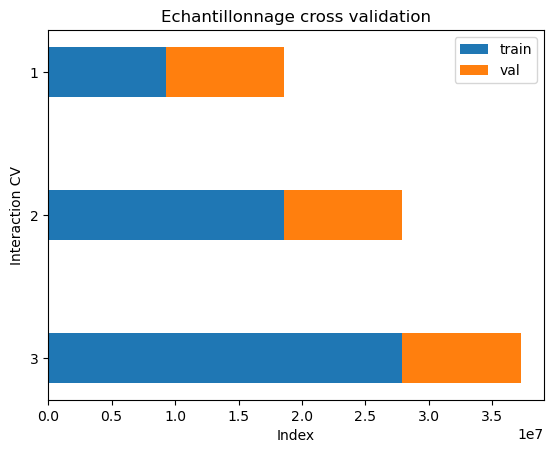

In [7]:
# Initialisation du TSCV
n_iter = 3
tscv = TimeSeriesSplit(n_splits=n_iter)

# Echantillonnage
train_lst = []
val_lst = []

for train_index, val_index in tscv.split(X):
    train_lst.append(train_index[-1])
    val_lst.append(val_index[-1] - val_index[0])
    
    # X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    # y_train, y_test = y.iloc[train_index], y.iloc[val_index]

train_tpl = tuple(train_lst)
val_tpl = tuple(val_lst)

# Tracage de l'échantillon
ind = np.arange(n_iter) + 1
width = 0.35

btrain = plt.barh(ind, train_tpl, width)
bval = plt.barh(ind, val_tpl, width, left=train_tpl)

plt.yticks(ind)
plt.gca().invert_yaxis()
plt.legend((btrain, bval), ("train", "val"))
plt.title('Echantillonnage cross validation')
plt.ylabel('Interaction CV')
plt.xlabel('Index')

plt.show()

In [8]:
%%time

# param_dist = {"max_depth": [25,50, 75],
#               "learning_rate" : [0.01,0.05,0.1],
#               "num_leaves": [300,900,1200],
#               "n_estimators": [200]
#              }

lg = lgb.LGBMClassifier()
param_dist = {"max_depth": [10, 25, 50]
              }

GCV = GridSearchCV(estimator=lg, cv=tscv.split(X), param_grid=param_dist, scoring="roc_auc", verbose=5, n_jobs=4)
GCV.fit(X, y)
GCV.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
pickle.dump(GCV, 

In [ ]:
%%time

params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }
         
model = lg.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8
)